<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предобработка</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#CatBoost-с-векторизироваными-признаками" data-toc-modified-id="CatBoost-с-векторизироваными-признаками-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoost с векторизироваными признаками</a></span></li><li><span><a href="#CatBoost-на-сгенерированых-фичах" data-toc-modified-id="CatBoost-на-сгенерированых-фичах-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoost на сгенерированых фичах</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Дополнительно,-предобученая-модель-Detoxify" data-toc-modified-id="Дополнительно,-предобученая-модель-Detoxify-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Дополнительно, предобученая модель Detoxify</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install swifter
!pip install pyarrow --upgrade

     |████████████████████████████████| 12.8 MB 2.5 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer, f1_score, plot_confusion_matrix, plot_roc_curve, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from catboost import CatBoostClassifier

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import requests
import json

RS = 22345
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# добавил библиотек
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
import en_core_web_sm
from tqdm.notebook import tqdm
import swifter
tqdm.pandas()
nltk.download('vader_lexicon')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=False)

In [5]:
#df = df.sample(5000).reset_index(drop=True) 

Посмотрим на данные

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [7]:
# Баланс классов
df['toxic'].value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

Данные не сбалансированы

In [8]:
pd.set_option('max_colwidth', 200)
df.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tid...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [9]:
df.query('toxic == 1').head()

,Unnamed: 0,text,toxic
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,12,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI...",1
16,16,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1
42,42,"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and no...",1
43,43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


Добавим Колонку с длиной текста и посмотрим на распределение


In [10]:
df['len'] = df['text'].apply(len)
df['len'].max()

5000

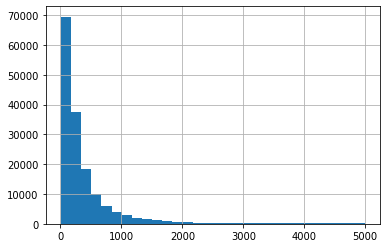

In [11]:
df['len'].hist(bins=30);

In [12]:
df.query('len > 4900')

,Unnamed: 0,text,toxic,len
1184,1184,"And \n\nPaganism\n\nSouthgate, who has a degree in theology and religious studies from Canterbury University, rejected Catholicism and moved towards neo-pagan and heathen groups that are ‘very loy...",0,4908
2413,2413,FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U U...,1,4999
3947,3947,"""\n\n(Ivo Banac)...A bit of nonteleological history\nOne of the great problems is that our understanding of the common and individual histories of the South Slavs and the other peoples of southeas...",0,4946
4167,4167,"ii CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL P...",1,5000
4704,4704,do go fuck off bastard\nDo Yyou Have a life?\ngo fuck off bastard and yank your cock through your ass. I hate you and hope you go away forever. lame is you fuck your mom. die die die and all that ...,1,4969
...,...,...,...,...
155754,155912,AIDS AIDS AIDS AIDS AIDS AIDS AIDSAIDS AIDS AIDS AIDS AIDS AIDS AIDSAIDS AIDS AIDS AIDS AIDS AIDS AIDSAIDS AIDS AIDS AIDS AIDS AIDS AIDSAIDS AIDS AIDS AIDS AIDS AIDS AIDSAIDS AIDS AIDS AIDS AIDS A...,1,5000
156158,156317,HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE...,1,5000
157582,157741,"""\n\n Made in the USA? http://rexcurry.net/wikipedialies.html \n\nThere are some regular writers on Wikipedia who knowingly engage in personal attacks and deletions (even of links) of anyone who e...",0,4912
158293,158452,"Originally born in OHIO,and raised on a yuppie farmh in a small town outside of dayton, ohio. Her mother is a professional and has worked for the government for almost 30 years and her father is r...",0,4976


Вывод \
Днанные не сбалансированы
большинство коментариев имеют длину до 500 символов

### Предобработка

Удалим из текста лишние символы, лематизируем 

In [13]:
stop_words = set(stopwords.words('english'))

In [16]:
nlp = en_core_web_sm.load()

In [17]:
def clear_text(text):
    clear = re.sub(r'[^a-zA-z]', ' ', text)
    doc = nlp(clear)
    words = [w.text for w in doc if w.text.lower() not in stop_words]
    text = ' '.join(words)
    text = ' '.join(text.split())
    return text


In [18]:
df['text'] = df['text'].swifter.progress_bar(True).apply(clear_text)

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

Добавим эмоциональную окраску текста

In [19]:
sid = SentimentIntensityAnalyzer()

In [20]:
def sentiment_text(text):
    '''
    
    Функция возвращает 4 значения:
    compound оценка тональности текса
    neg доля негативных слов
    neu доля нейтральных слов
    pos доля позитивных слов
    
    '''
    compound = sid.polarity_scores(text)['compound']
    neg = sid.polarity_scores(text)['neg']
    neu = sid.polarity_scores(text)['neu']
    pos = sid.polarity_scores(text)['pos']
    return compound, neg, neu, pos

In [21]:
df[['compound','neg','neu','pos']] = df['text'].swifter.progress_bar(True).apply(sentiment_text).apply(pd.Series)

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

Создадим столбец с количеством нецензурных слов в тексте

In [22]:
# возьмем список нецензурных слов и добавим его в переменную  bad_words
url = 'https://raw.githubusercontent.com/LDNOOBW/naughty-words-js/master/en.json'
response = requests.get(url)
bad_words = json.loads(response.text)

In [23]:
def count_bad_words(text):
    '''Функция принимает текст и возвращает сколько слов совпавших с bad_words'''
    count = 0
    words = text.split()
    for word in words:
        if word.lower() in bad_words:
            count += 1
    return count

In [24]:
df['bad_words_count'] = df['text'].swifter.progress_bar(True).apply(count_bad_words)

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

In [25]:
df.head()

,Unnamed: 0,text,toxic,len,compound,neg,neu,pos,bad_words_count
0,0,Explanation edits made username Hardcore Metallica Fan reverted vandalisms closure GAs voted New York Dolls FAC please remove template talk page since retired,0,264,0.5574,0.000,0.820,0.180,1
1,1,aww matches background colour seemingly stuck Thanks talk January UTC,0,112,0.2263,0.155,0.620,0.225,0
2,2,Hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info,0,233,-0.2415,0.158,0.721,0.121,0
3,3,make real suggestions improvement wondered section statistics later subsection types accidents think references may need tidying exact format ie date format etc later one else first preferences fo...,0,622,0.2500,0.082,0.801,0.117,0
4,4,sir hero chance remember page,0,67,0.6808,0.000,0.349,0.651,0


CatBoost умеет работать с текстом, для него не будем преобразовывать текс в вектора

In [26]:
# Для Catboost
X = df[['text', 'len', 'bad_words_count', 'compound', 'neg', 'neu', 'pos']].values
y = df['toxic']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, test_size=0.2, stratify = y, random_state=RS)

разделим данные для других моделей

In [27]:
# Для векторов
X = df[['text', 'len', 'bad_words_count', 'compound', 'neg', 'neu', 'pos']]
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify = y, random_state=RS)

In [28]:
# скорер
scorer = make_scorer(f1_score)

## Обучение

### Logistic Regression

In [29]:
%%time

lr_params = {
    'logistic__max_iter': range(200, 5000, 100)
}


lr = LogisticRegression(class_weight='balanced', random_state=RS)    




preparing = ColumnTransformer([('vectorizer', TfidfVectorizer(), 'text'),
                               ('num', StandardScaler(), ['len', 'bad_words_count', 'compound', 'neg', 'neu', 'pos'])])


pipeline = Pipeline([
    ('preparing', preparing),
    ('logistic', lr)
])


lr_random_search = RandomizedSearchCV(
    pipeline, param_distributions=lr_params,
    n_iter=5,
    cv=5,
    random_state=RS,
    scoring=scorer)


lr_random_search.fit(X_train, y_train)

lr_best = lr_random_search.best_estimator_
lr_score = -lr_random_search.best_score_
lr_fit_time = lr_random_search.cv_results_['mean_fit_time'][lr_random_search.best_index_]
lr_score_time = lr_random_search.cv_results_['mean_score_time'][lr_random_search.best_index_]

CPU times: user 31min 20s, sys: 36min 33s, total: 1h 7min 53s
Wall time: 1h 8min


In [30]:
print("Лучшая оценка: ", -lr_score)
print(f'Время обучения: {round(lr_fit_time // 60)} минут {round(lr_fit_time % 60)} секунд')
print(f'Время предсказания: {round(lr_score_time // 60)} минут {round(lr_score_time % 60, 2)} секунд')

Лучшая оценка:  0.7385562772441168
Время обучения: 2 минут 26 секунд
Время предсказания: 0 минут 0.91 секунд


Метрика меньше необходимой нам 

### CatBoost

In [31]:
# CatBoost текстом
params_cat = {'learning_rate': np.arange(0.1, 0.5, 0.1), 
          'depth': range(3, 7, 1), 
          'iterations': range(100, 3000, 500)
             }

Cat = CatBoostClassifier(eval_metric='F1', random_state=RS, text_features = [0],
                         auto_class_weights='SqrtBalanced',
                         verbose = False)

random_search_cat_t = RandomizedSearchCV(estimator=Cat, 
                                   param_distributions=params_cat, 
                                   n_iter=5, 
                                   cv=5, 
                                   random_state=RS, 
                                   scoring=scorer,
                                   n_jobs=-1)

random_search_cat_t.fit(X_train_cat, y_train_cat)

Cat_best_t = random_search_cat_t.best_estimator_
Cat_score_t = -random_search_cat_t.best_score_
Cat_fit_time_t = random_search_cat_t.cv_results_['mean_fit_time'][random_search_cat_t.best_index_]
Cat_score_time_t = random_search_cat_t.cv_results_['mean_score_time'][random_search_cat_t.best_index_]

In [32]:
print("Лучшая оценка: ", -Cat_score_t)
print(f'Время обучения: {round(Cat_fit_time_t // 60)} минут {round(Cat_fit_time_t % 60)} секунд')
print(f'Время предсказания: {round(Cat_score_time_t // 60)} минут {round(Cat_score_time_t % 60, 2)} секунд')

Лучшая оценка:  0.7760629598667471
Время обучения: 19 минут 49 секунд
Время предсказания: 0 минут 1.81 секунд


Метрика лучше чем у логистической регресии и больше минимильно необходимой нам

### CatBoost с векторизироваными признаками

In [44]:
%%time

params_cat = {
    'cat__learning_rate': np.arange(0.1, 0.5, 0.1), 
    'cat__depth': range(3, 7, 1),
    'cat__iterations': range(100, 1500, 500)
}


cat = CatBoostClassifier(eval_metric='F1',
                         random_state=RS,
                         auto_class_weights='SqrtBalanced',
                        verbose = False)




preparing = ColumnTransformer([('vectorizer', TfidfVectorizer(), 'text'),
                               ('num', StandardScaler(), ['len', 'bad_words_count', 'compound', 'neg', 'neu', 'pos'])])


pipeline = Pipeline([
    ('preparing', preparing),
    ('cat', cat)
])


cat_random_search_v = RandomizedSearchCV(
    pipeline, param_distributions=params_cat, n_iter=5, cv=5, random_state=RS, scoring=scorer)

cat_random_search_v.fit(X_train, y_train)

cat_best_v = cat_random_search_v.best_estimator_
cat_score_v = -cat_random_search_v.best_score_
cat_fit_time_v = cat_random_search_v.cv_results_['mean_fit_time'][cat_random_search_v.best_index_]
cat_score_time_v = cat_random_search_v.cv_results_['mean_score_time'][cat_random_search_v.best_index_]

CPU times: user 4h 53min 20s, sys: 3min 4s, total: 4h 56min 25s
Wall time: 4h 57min 36s


In [46]:
print("Лучшая оценка: ", -cat_score_v)
print(f'Время обучения: {round(cat_fit_time_v // 60)} минут {round(cat_fit_time_v % 60)} секунд')
print(f'Время предсказания: {round(cat_score_time_v // 60)} минут {round(cat_score_time_v % 60, 2)} секунд')

Лучшая оценка:  0.7792551250982882
Время обучения: 20 минут 20 секунд
Время предсказания: 0 минут 1.34 секунд


Самый высокий результат среди рассмотреных моделей

### CatBoost на сгенерированых фичах

In [48]:
X_train_f = X_train[['len', 'bad_words_count', 'compound', 'neg', 'neu', 'pos']].values

In [50]:
params_cat = {'learning_rate': np.arange(0.1, 0.5, 0.1), 
          'depth': range(3, 10, 1), 
          'iterations': range(100, 3000, 500)
             }

Cat = CatBoostClassifier(eval_metric='F1', random_state=RS,
                         auto_class_weights='SqrtBalanced',
                         early_stopping_rounds = 300,
                         verbose = False,)

random_search_cat_f = RandomizedSearchCV(estimator=Cat, 
                                   param_distributions=params_cat, 
                                   n_iter=5, 
                                   cv=5, 
                                   random_state=RS, 
                                   scoring=scorer,
                                   n_jobs=-1)

random_search_cat_f.fit(X_train_f, y_train)

cat_best_f = random_search_cat_f.best_estimator_
cat_score_f = -random_search_cat_f.best_score_
cat_fit_time_f = random_search_cat_f.cv_results_['mean_fit_time'][random_search_cat_f.best_index_]
cat_score_time_f = random_search_cat_f.cv_results_['mean_score_time'][random_search_cat_f.best_index_]

In [52]:
print("Лучшая оценка: ", -cat_score_f)
print(f'Время обучения: {round(cat_fit_time_f // 60)} минут {round(cat_fit_time_f % 60)} секунд')
print(f'Время предсказания: {round(cat_score_time_f // 60)} минут {round(cat_score_time_f % 60, 2)} секунд')

Лучшая оценка:  0.655465491107199
Время обучения: 0 минут 16 секунд
Время предсказания: 0 минут 0.07 секунд


### Тестирование лучшей модели

In [58]:
prediction = cat_best_v.predict(X_test)
f = f1_score(y_test_cat, prediction)

prediction = cat_best_v.predict(X_test)
a = accuracy_score(y_test, prediction)
print("F1 score:", f)
print("accuracy:", a)

F1 score: 0.7816055625790139
accuracy: 0.9566213628801908


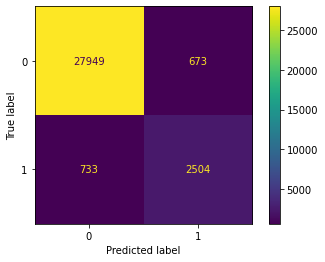

In [59]:
plot_confusion_matrix(Cat_best_t, X_test_cat, y_test);

In [60]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

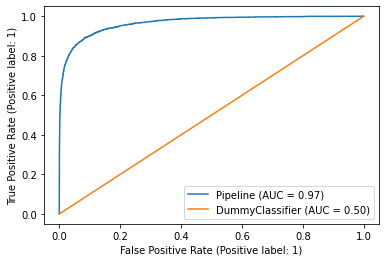

In [61]:
fig = plot_roc_curve(cat_best_v,  X_test, y_test)
plot_roc_curve(dummy,  X_test, y_test, ax=fig.ax_);

### Дополнительно, предобученая модель Detoxify

Даную модель рассмотрел в Google Colab
[notebook](https://colab.research.google.com/drive/10tynAw3NoKEEN5Q9VKTIImIq_BpQkpS6?usp=sharing)\
Модель в результате выдает 6 параметров оценки текста (от 0 до 1)\
- `toxicity`: Токсичность текста,
- `severe_toxicity`: Тяжесть токсичности,
- `obscene`: непристойность текста,
- `threat`: Угрозы в тексте,
- `insult`: Оскарбления,
- `identity_attack`: Переход на личности

Колонка `predict` сформирована из значний `toxicity` с порогом 0,5\
Результат предсказаний этой модели для всего df рассмотрм ниже

In [63]:
Detoxify_df = pd.read_csv('data/new_toxic_comments.csv')

In [65]:
Detoxify_df.head()

,Unnamed: 0,text,toxic,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,predict
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",0,0.000817,0.000105,0.000183,0.000106,0.000177,0.000135,0.0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0.000639,0.000117,0.000180,0.000122,0.000177,0.000136,0.0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",0,0.000923,0.000105,0.000178,0.000111,0.000181,0.000139,0.0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tid...",0,0.000526,0.000134,0.000190,0.000136,0.000179,0.000146,0.0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0,0.000923,0.000109,0.000166,0.000135,0.000185,0.000146,0.0


In [66]:
f = f1_score(Detoxify_df['toxic'], Detoxify_df['predict'])
a = accuracy_score(Detoxify_df['toxic'], Detoxify_df['predict'])
print("F1 score:", f)
print("accuracy:", a)

F1 score: 0.9404556166535744
accuracy: 0.9881036084674686


Результат уже предобученой модели сильно лучше чем у всех рассмотреных ранее

## Выводы

В ходе работы проведена подготовка данных для рассмотрения в разных моделях\
Были созданы фичи с эмоциональной окраской текста, длиной текста, количеством нецензурных слов\
Были рассмотрены модели:
- Модель логистической регресии 
- CatBoost c использованием встроеной функции для построения модели на текстовых данных, и без неё
- CatBoost только на фичах полученых в результате предобработки данных
Так же отдельно для предсказания была использована уже предобученая модель  Detoxify

Самый лучшей результат среди моделей обученых на предоставленых данных оказалась модель градиентного бустинга обученая на сгенерированых фичах и без использования встроеной функции обработки текста\
результат работы модели на тестовых данных: F1 0,78

Результат работы модели Detoxify, предобученой для определения тональности текста, на всех данных F1: 0.94 